In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump, load

from matplotlib.colors import ListedColormap

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA 

# classification algorithm
from sklearn import svm 

# metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_curve, auc, roc_auc_score

# model selection and parameter tuning
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV

# yellowbrick library  #pip install yellowbrick
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import ClassificationReport

In [24]:
def data_encoder(train, test):
    """Encodes the sets. Takes as arguments train-test sets. 
    Fits on train and transforms both."""
    encoder = OneHotEncoder()
    encoder.fit(train)
    train_encoded = encoder.transform(train).toarray()
    test_encoded = encoder.transform(test).toarray()
    return train_encoded, test_encoded

In [25]:
csv_names = {
    'monk1': ['monks-1.train', 'monks-1.test'] 
    ,'monk2': ['monks-2.train', 'monks-2.test']
    ,'monk3': ['monks-3.train', 'monks-3.test']
    ,'cup': ['ML-CUP22-TR.csv', 'ML-CUP22-TS.csv']
    ,'internal_cup': ['ML-CUP22-INTERNAL-TR.csv', 'ML-CUP22-INTERNAL-TS.csv']
 }

def import_df(string, type):
    """Imports a dataframe from csv file. 
    type = 'monk' OR 'cup'. 
    sting = .csv path"""
    if type == 'monk':
        dataframe = pd.read_csv('../data/{}'.format(string), header=None, delimiter=' ')
    elif type == 'cup':
        dataframe = pd.read_csv('../data/{}'.format(string), header=None)
        dataframe.drop(0, axis=1, inplace=True)
    return dataframe

def set_attributes(dataframe, type):
    """Takes a dataframe and sets corresponding attribute names."""
    if type == 'monk':
        df = dataframe.drop(columns=0)
        columns = ['class', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id']
        df.columns = columns
    else:
        df = dataframe
    return df #..

def X_y_split(dataframe, type):
    """Split dataframe in X and y sets. Takes dataframe as an argument.
    In case of cup it gives y_1 and y_2."""
    
    if type == 'monk':
        X_df = dataframe.copy()
        y_df_1 = X_df['class']
        X_df = X_df.drop(columns='id')
        X_df = X_df.drop(columns='class')
        X_df = X_df.values  
        y_df_2 = []
    elif type == 'cup':
        X_df = dataframe.iloc[:, :9].to_numpy().astype(np.float64)
        y_df_1 = dataframe.iloc[:, 9:10].to_numpy().astype(np.float64)
        y_df_2 = dataframe.iloc[:, 10:].to_numpy().astype(np.float64)
    return X_df, y_df_1, y_df_2


def load_data(string, type):
    """Loads Dataframe"""
    dataframe = import_df(string, type)
    df = set_attributes(dataframe, type)
    X_df, y_df_1, y_df_2 = X_y_split(df, type)
    return X_df, y_df_1, y_df_2

### data Prep

In [6]:
X_train1, y_train1, empty  = load_data(csv_names['monk1'][0], 'monk')
X_test1, y_test1, empty    = load_data(csv_names['monk1'][1], 'monk')
X_train2, y_train2, empty  = load_data(csv_names['monk2'][0], 'monk')
X_test2, y_test2, empty    = load_data(csv_names['monk2'][1], 'monk')
X_train3, y_train3, empty  = load_data(csv_names['monk3'][0], 'monk')
X_test3, y_test3, empty    = load_data(csv_names['monk3'][1], 'monk')

In [7]:
X_train1_encoded, X_test1_encoded = data_encoder(X_train1, X_test1)
X_train2_encoded, X_test2_encoded = data_encoder(X_train2, X_test2)
X_train3_encoded, X_test3_encoded = data_encoder(X_train3, X_test3)

X_train1_encoded.shape

(124, 17)

### running SVM

In [51]:
def ParameterTune(X_train, y_train, X_test, y_test):
  #Create a svm Classifier
  clf = svm.SVC(random_state=42)

  # Grid Search
  param_grid = [
    {
      'C': range(1,100)
      ,'kernel': ['linear', 'rbf', 'poly']
    },
    {
      'C': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 10, 100, 1000, 10000]
      ,'kernel': ['linear', 'rbf', 'poly']
      ,'gamma': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 10, 100, 1000, 10000]
    }
  ]
    
  cv = StratifiedKFold(n_splits=5, shuffle=True)    

  grid_search = GridSearchCV(clf, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=4)
  model = grid_search.fit(X_train, y_train)
  model = grid_search.best_estimator_

  y_pred = model.predict(X_test)

  learning_curve = LearningCurve(model, scoring='accuracy')
  learning_curve.fit(X_train, y_train)  

  return y_test, y_pred, model, learning_curve 

Fitting 5 folds for each of 660 candidates, totalling 3300 fits
Model:  SVC(C=100, gamma=0.05, random_state=42)
params:  {'ax': <AxesSubplot:>, 'cv': None, 'estimator': SVC(C=100, gamma=0.05, random_state=42), 'exploit_incremental_learning': False, 'groups': None, 'n_jobs': 1, 'pre_dispatch': 'all', 'random_state': 42, 'scoring': 'accuracy', 'shuffle': False, 'train_sizes': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]), 'C': 100, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.05, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'shrinking': True, 'tol': 0.001, 'verbose': False}
TR Accuracy:  1.0
TS Accuracy:  1.0
Accuracy 1.0
F1-score [1. 1.]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       216
           1       1.00      1.00      1.00       216

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.

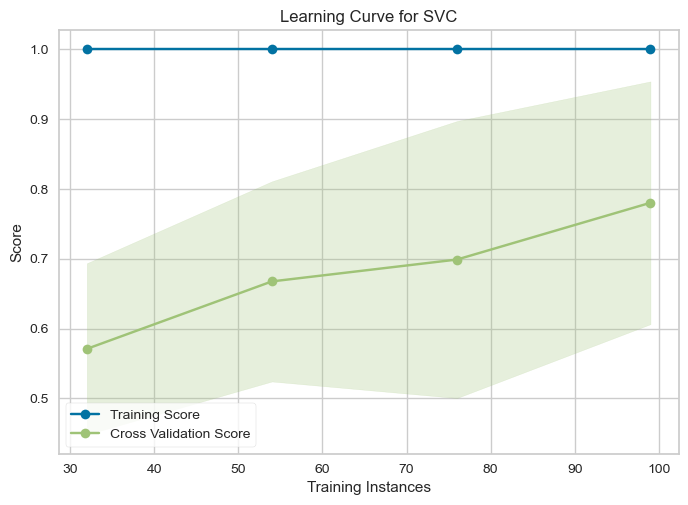

<AxesSubplot:title={'center':'Learning Curve for SVC'}, xlabel='Training Instances', ylabel='Score'>

In [59]:
y_test, y_pred, model, lc = ParameterTune(X_train1_encoded, y_train1, X_test1_encoded, y_test1)

score_train = model.score(X_train1_encoded, y_train1)
score_test = model.score(X_test1_encoded, y_test1)

print('Model: ', model)
print('params: ', lc.get_params())
print('TR Accuracy: ', score_train) #% accuracy_score(y_test, y_pred))
print('TS Accuracy: ', score_test) #% accuracy_score(y_test, y_pred))
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

lc.show()

Fitting 5 folds for each of 660 candidates, totalling 3300 fits
Model:  SVC(C=10000, gamma=0.01, random_state=42)
params:  {'ax': <AxesSubplot:>, 'cv': None, 'estimator': SVC(C=10000, gamma=0.01, random_state=42), 'exploit_incremental_learning': False, 'groups': None, 'n_jobs': 1, 'pre_dispatch': 'all', 'random_state': 42, 'scoring': 'accuracy', 'shuffle': False, 'train_sizes': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]), 'C': 10000, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.01, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'shrinking': True, 'tol': 0.001, 'verbose': False}
TR Accuracy:  1.0
TS Accuracy:  1.0
Accuracy 1.0
F1-score [1. 1.]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       290
           1       1.00      1.00      1.00       142

    accuracy                           1.00       432
   macro avg       1.00      1.00  

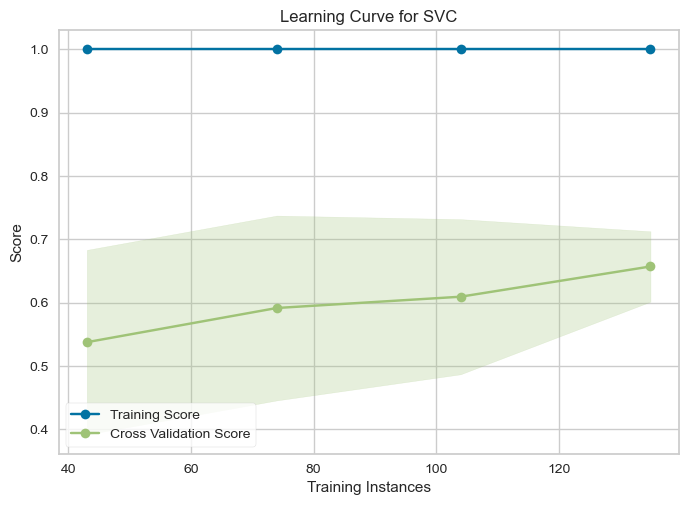

<AxesSubplot:title={'center':'Learning Curve for SVC'}, xlabel='Training Instances', ylabel='Score'>

In [60]:
y_test, y_pred, model, lc = ParameterTune(X_train2_encoded, y_train2, X_test2_encoded, y_test2)

score_train = model.score(X_train2_encoded, y_train2)
score_test = model.score(X_test2_encoded, y_test2)

print('Model: ', model)
print('params: ', lc.get_params())
print('TR Accuracy: ', score_train) #% accuracy_score(y_test, y_pred))
print('TS Accuracy: ', score_test) #% accuracy_score(y_test, y_pred))
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

lc.show()

Fitting 5 folds for each of 660 candidates, totalling 3300 fits
Model:  SVC(C=1, kernel='linear', random_state=42)
params:  {'ax': <AxesSubplot:>, 'cv': None, 'estimator': SVC(C=1, kernel='linear', random_state=42), 'exploit_incremental_learning': False, 'groups': None, 'n_jobs': 1, 'pre_dispatch': 'all', 'random_state': 42, 'scoring': 'accuracy', 'shuffle': False, 'train_sizes': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]), 'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'shrinking': True, 'tol': 0.001, 'verbose': False}
TR Accuracy:  0.9344262295081968
TS Accuracy:  0.9722222222222222
Accuracy 0.9722222222222222
F1-score [0.97142857 0.97297297]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       204
           1       1.00      0.95      0.97       228

    accuracy            

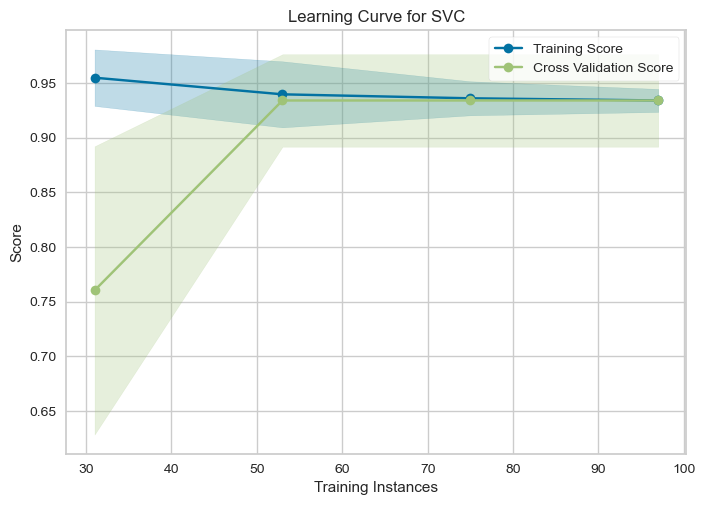

<AxesSubplot:title={'center':'Learning Curve for SVC'}, xlabel='Training Instances', ylabel='Score'>

In [61]:
y_test, y_pred, model, lc = ParameterTune(X_train3_encoded, y_train3, X_test3_encoded, y_test3)

score_train = model.score(X_train3_encoded, y_train3)
score_test = model.score(X_test3_encoded, y_test3)

print('Model: ', model)
print('params: ', lc.get_params())
print('TR Accuracy: ', score_train) #% accuracy_score(y_test, y_pred))
print('TS Accuracy: ', score_test) #% accuracy_score(y_test, y_pred))
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

lc.show()